# Noise reduction with Median & Bilateral Filters

There are many situations where you might want to remove "noise" from an image. This high frequency variance of pixel intensities can come from many places, such as low light in photography, or too few render (light ray) samples in a raytraced CG image. There are many different techniques to remove noise, and in recent years more novel approaches have emerged with machine learning-based de-noising. In this notebook, however, we will focus on two classic noise reduction algorithms: Median Filters, and Bilateral Filters.

---

You can think of noise as any high frequency variants in pixel intensities which on its own don't add any useful detail or information about the scene.

In [1]:
# Import Libraries.
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Median Filter

Median blur filtering is a nonlinear filtering technique that is most commonly used to remove **salt-and-pepper** noise from images. As the name suggests, salt-and-pepper noise shows up as randomly occurring white and black pixels that are sharply different from the surrounding. In color images, salt-and-pepper noise may appear as small random color spots.

Following patch has a salt-and-pepper noise, which is evident from the fact that the central pixel has a value way higher than the neighboring pixels.

$$
\begin{bmatrix}
30 & 32 & 29\\
31 & 255 & 35\\
35 & 30 & 33
\end{bmatrix}
$$

The median filter takes in only the pixel values in the neighborhood of the central pixel, sorts the list of values, and then replaces the value of the central pixel with the median value of the sorted list. In this case, the sorted list becomes 

$$[29, 30, 30, 31, 32, 33, 35, 35, 255]$$

Thus, the median value is 32, and we replace the central pixel with 32. That's how the noise is removed.
$$
\begin{bmatrix}
30 & 32 & 29\\
31 & 32 & 35\\
35 & 30 & 33
\end{bmatrix}
$$

This is repeated for each pixel of the image.

---

### Median blur syntax

dst = cv2.medianBlur(src, ksize)

`dst`: Destination array of the same size and type as src.

This function has __2 required arguments__:

1. `src`: input 1-, 3-, or 4-channel image; when ksize is 3 or 5, the image depth should be CV_8U, CV_16U, or CV_32F, for larger aperture sizes, it can only be CV_8U.
2. `ksize`:	aperture linear size; it must be an odd number and greater than 1, for example: 3, 5, 7, ...

The reason why ksize must be an odd number is because this represents essentially the distance of neighbors to include.

Text(0.5, 1.0, 'Median filter applied')

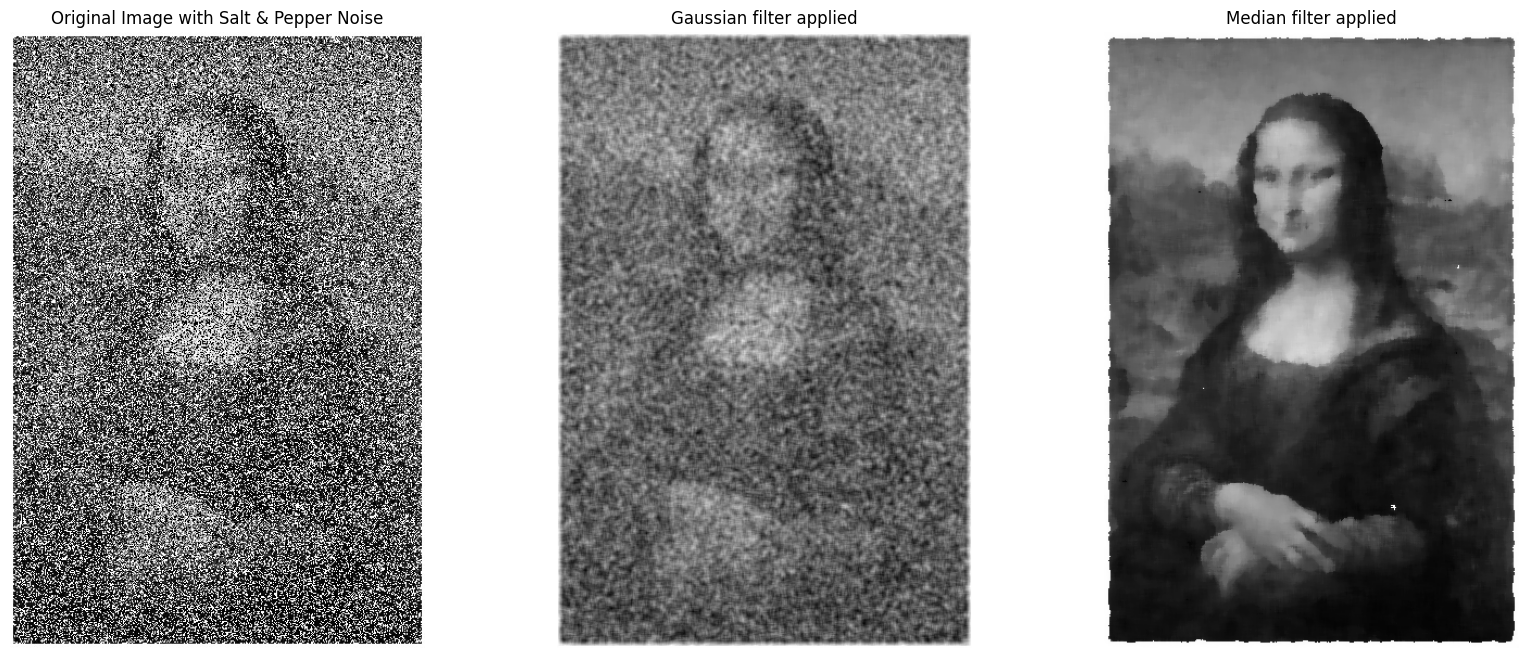

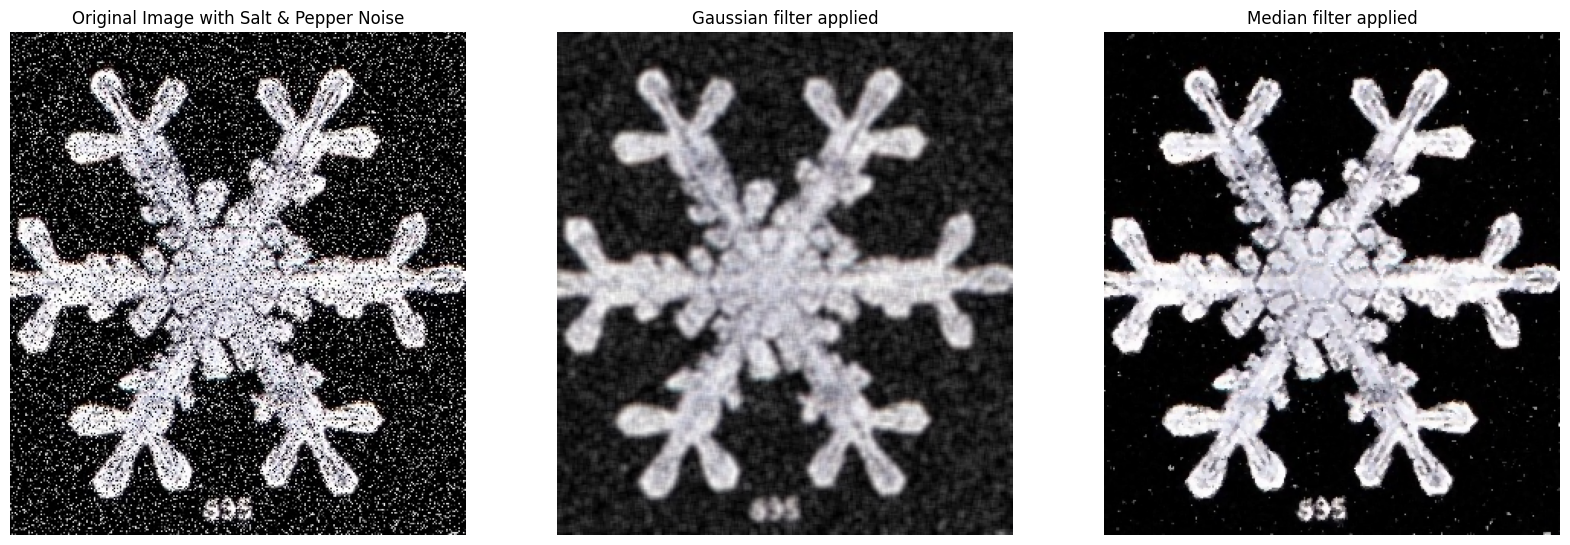

In [2]:
# Load an image with salt and pepper noise.
img1 = cv2.imread("../module10/mona_lisa.jpg")
img2 = cv2.imread("../module10/ice-flakes-microscopy-salt-and-pepper-noise.jpg")

# Apply median filter.
img1_median = cv2.medianBlur(img1, 9)
img2_median = cv2.medianBlur(img2, 3)

# Apply Gaussian filter for comparison.
img1_gaussian = cv2.GaussianBlur(img1, (5, 5), cv2.BORDER_DEFAULT)
img2_gaussian = cv2.GaussianBlur(img2, (5, 5), cv2.BORDER_DEFAULT)

plt.figure(figsize = (20, 8))
plt.subplot(131); plt.axis('off'); plt.imshow(img1[:,:,::-1]);          plt.title('Original Image with Salt & Pepper Noise')
plt.subplot(132); plt.axis('off'); plt.imshow(img1_gaussian[:,:,::-1]); plt.title('Gaussian filter applied')
plt.subplot(133); plt.axis('off'); plt.imshow(img1_median[:,:,::-1]);   plt.title('Median filter applied')
plt.figure(figsize = (20, 10))
plt.subplot(131); plt.axis('off'); plt.imshow(img2[:,:,::-1]);          plt.title('Original Image with Salt & Pepper Noise')
plt.subplot(132); plt.axis('off'); plt.imshow(img2_gaussian[:,:,::-1]); plt.title('Gaussian filter applied')
plt.subplot(133); plt.axis('off'); plt.imshow(img2_median[:,:,::-1]);   plt.title('Median filter applied')

In both these examples it's worth calling out that we haven't done any special cases or considerations for borders, so anywhere that there might have been a clear border between say a dark and a bright area that border might have been adjusted or influenced by the fact that we're using a median value.

---

## Bilateral Filtering

This is considered a non-linear edge preserving and noise reduction smoothing filter. There are two objectives on an edge preserving filter.

1. Smooth the image
2. Don't smooth the edges / color boundaries

We do want to remove the noise, but we don't want to smooth the edges or the color boundaries. In other words, we don't want to make all the edges fuzzy, we want to keep those nice and crisp.

What this means is we have to account for edges which with the bilateral blur means intentionally only trying to blur pixels together of similar colors and brightness.

Consider this 3x3 image patch, shown below.

$$
\begin{bmatrix}
30 & 200 & 239\\
31 & 220 & 235\\
35 & 210 & 233
\end{bmatrix}
$$

The fisrt column has values around 30 and 35, the middle column has values of 200 and then more around 230 to 240 in the third column. If we were to convert this to an actual grayscale image it would look like it's going from dark to bright when we're going from left to right.

As such we should have the algorithm not take simply a median of all the neighbors around it but to consider only the colors similar enough to the target pixel to blur together. It's a weighted average of nearby pixels but taking into account the variations of intensity and color in order to preserve edges. The more dislike and neighboring pixel is to our target pixel the less influence it will have on the weighted average color.

---

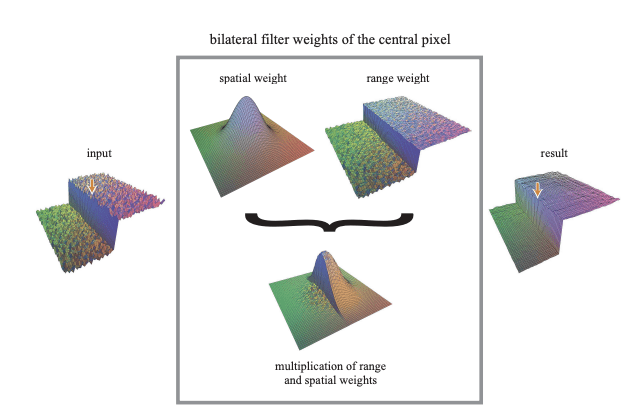

In this visualization on the left there is an image where the intensities or brightness of the pixels are represented by a vertical 3D displacement, this is a noisy image where the left side is dark and the right half is bright, but both halves contain noise.

In the middle you see the two key parameters of this filter, the __spatial weight__ which is how much farther away pixels are influencing the filtering, the __range weight__ which ensures that only colors that are close enough to the target pixel influence the final result.

In this image, we are sampling a pixel on the bright side of an edge and so the darker pixels are weighted to be very small. When we multiply the spatial and range weights together we get the result on the right hand side. What's being visualized here is actually after you've done this multiplication once per each individual pixel in the image.

---

### Blateral Filter in OpenCV

dst = cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dts[, borderType]])

__Parameters__:

+ `src`: Source 8-bit or floating-point, 1-channel or 3-channel image.
+ `dst`: Destination image of the same size and type as src.
+ `d`: Diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace.
+ `sigmaColor`: Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.
+ `sigmaSpace`: Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor). When d > 0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace,
+ `borderType`: Border mode used to extrapolate pixels outside of the image.

---

### <font style="color:rgb(50,120,229)">Here, we are going to apply it on an image that has Gaussian noise. </font>
Gaussian noise can be caused by poor illumination, high temperature, noise in electronic circuit etc. Let's see the application of Bilateral filter on an image with Gaussian noise. The following images have artificially added noise: 20% and 40% noise for first and second images respectively. Feel free to play with the values of radius, sigma color and sigma space.

Text(0.5, 1.0, 'Bilateral blur Result')

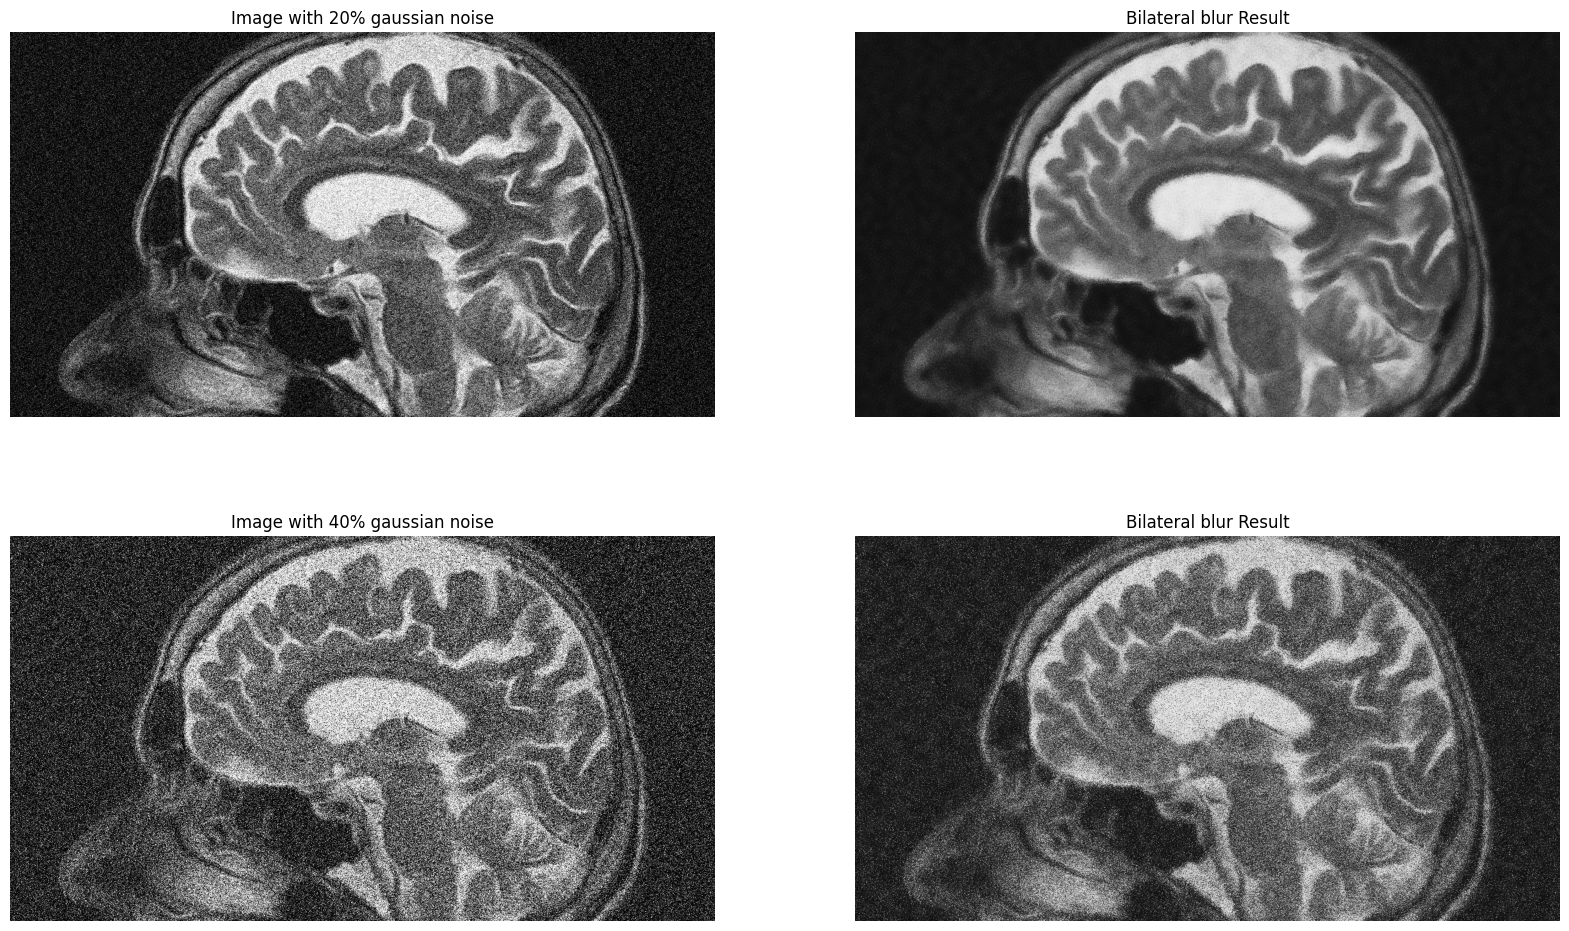

In [3]:
# Load image with gaussian noise.
image1 = cv2.imread("../module10/mri-skull-20-percent-gaussian-noise.jpg")
image2 = cv2.imread("../module10/mri-skull-40-percent-gaussian-noise.jpg")

# Diameter of the pixel neighborhood used during filtering.
dia = 20

# Larger the value the distant colours will be mixed together
# to produce areas of semi equal colors.
sigmaColor = 200

# Larger the value more the influence of the farther placed pixels
# as long as their colors are close enough.
sigmaSpace = 100

# Apply bilateralFilter.
dst1 = cv2.bilateralFilter(image1, dia, sigmaColor, sigmaSpace)
dst2 = cv2.bilateralFilter(image2, dia, sigmaColor, sigmaSpace)

plt.figure(figsize = (20, 12))
plt.subplot(221); plt.axis('off'); plt.imshow(image1[:,:,::-1]); plt.title("Image with 20% gaussian noise")
plt.subplot(222); plt.axis('off'); plt.imshow(dst1[:,:,::-1]);   plt.title("Bilateral blur Result")
plt.subplot(223); plt.axis('off'); plt.imshow(image2[:,:,::-1]); plt.title("Image with 40% gaussian noise")
plt.subplot(224); plt.axis('off'); plt.imshow(dst2[:,:,::-1]);   plt.title("Bilateral blur Result")

In both cases above, the images are smoothed out but you haven't completely reduced the noise, however we do also have a better preservation of the edges, all in all this is a modest result which is a good compromise between having no noise in the image but then everything is overly blurred while still preserving some of the details.

---

### <font style="color:rgb(50,120,229)">Skin smoothing filters</font>
Skin smoothing filters of Instagram, Facebook and even inbuilt camera app these days, can also be created using OpenCV bilateral filter. The following examples show the implementation.

Text(0.5, 1.0, 'Bilateral Filter')

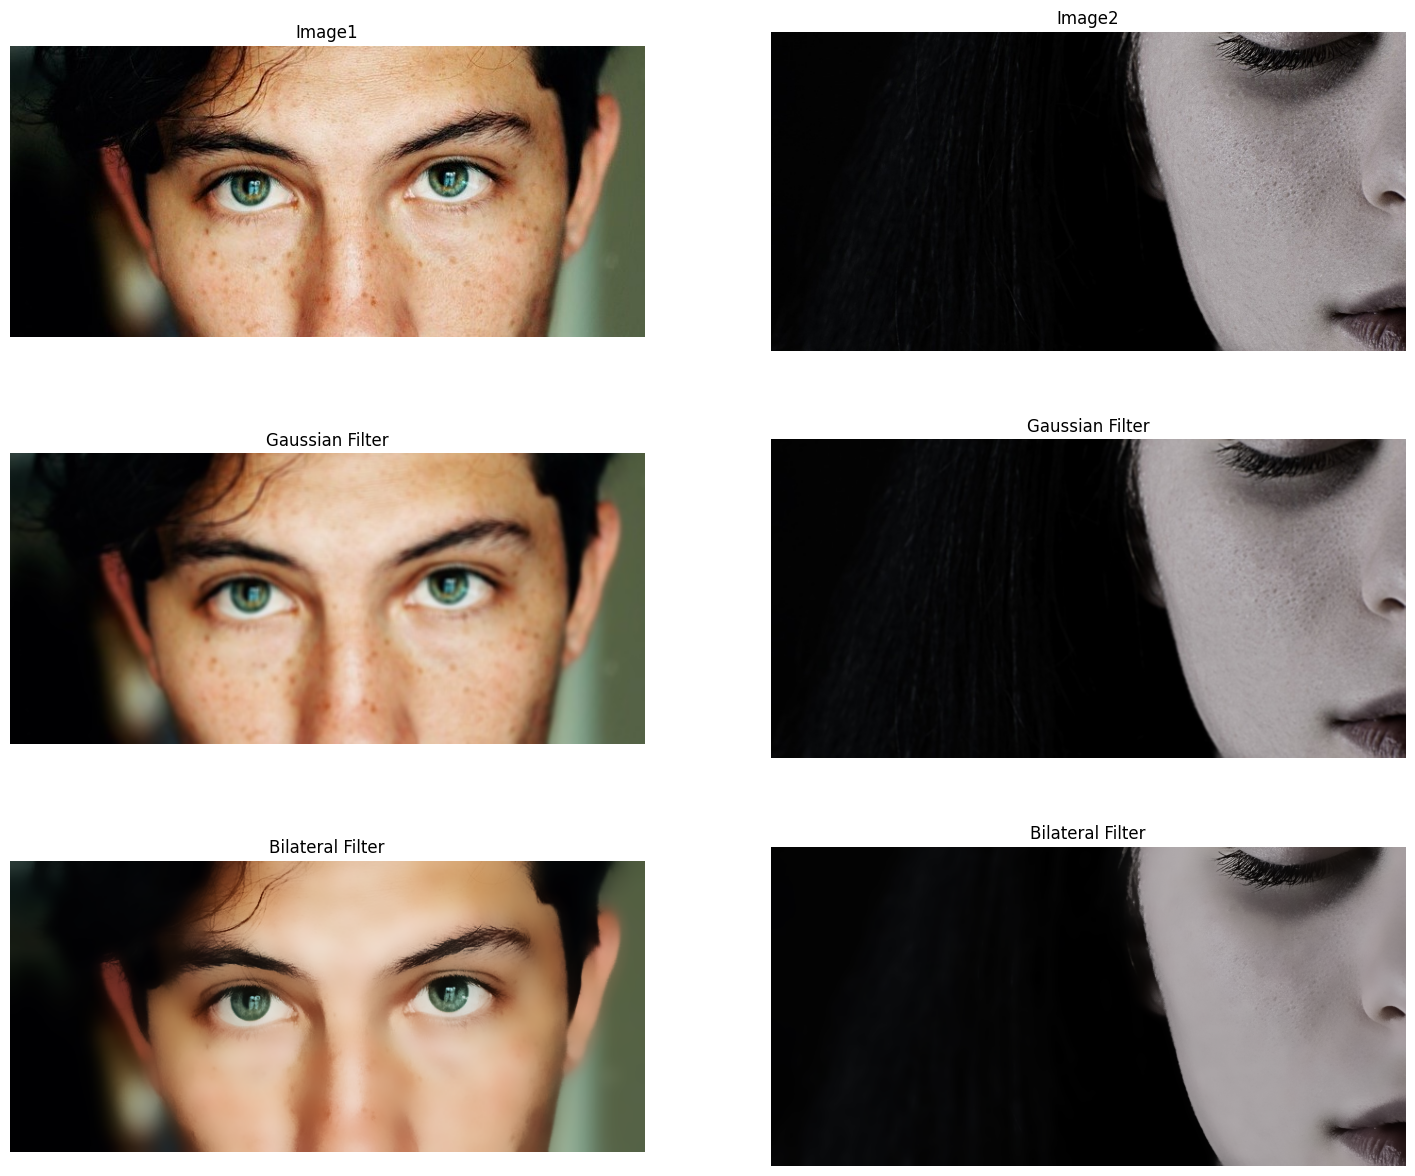

In [4]:
# Load images.
img1 = cv2.imread("../module10/face-original.jpg")
img2 = cv2.imread("../module10/girl-skin.jpg")

# Apply Gaussian filter for comparison.
img1_gaussian = cv2.GaussianBlur(img1, (5, 5), cv2.BORDER_DEFAULT)
img2_gaussian = cv2.GaussianBlur(img2, (5, 5), cv2.BORDER_DEFAULT)

# Apply bilateralFilter.
img1_bilateral = cv2.bilateralFilter(img1, d=25, sigmaColor=90, sigmaSpace=40)
img2_bilateral = cv2.bilateralFilter(img2, d=30, sigmaColor=65, sigmaSpace=15)

# Display.
plt.figure(figsize = (18, 15))
plt.subplot(321); plt.axis('off'); plt.imshow(img1[:,:,::-1]);           plt.title('Image1')
plt.subplot(322); plt.axis('off'); plt.imshow(img2[:,:,::-1]);           plt.title('Image2')
plt.subplot(323); plt.axis('off'); plt.imshow(img1_gaussian[:,:,::-1]);  plt.title('Gaussian Filter')
plt.subplot(324); plt.axis('off'); plt.imshow(img2_gaussian[:,:,::-1]);  plt.title('Gaussian Filter')
plt.subplot(325); plt.axis('off'); plt.imshow(img1_bilateral[:,:,::-1]); plt.title('Bilateral Filter')
plt.subplot(326); plt.axis('off'); plt.imshow(img2_bilateral[:,:,::-1]); plt.title('Bilateral Filter')

### Conclusion
* Median filtering works best on images with salt and pepper type noise.
* Bilateral filtering helps smooth noise while maintaining sharp edges.